In [45]:
import xarray as xr
from glob import glob
from datetime import datetime
import yaml
import sys
sys.path.append('../../')

import plotting

from conf.global_settings import OUTPUT_DIR
from utils.file_utils import get_date
from transformations.transformation import Transformation

In [46]:
ds_name = "TELLUS_GRAC_L3_CSR_RL06_OCN_v04"
hemisphere = ''
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [47]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.nc*')
if hemisphere:
    ds_granules = [g for g in ds_granules if hemisphere in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/TELLUS_GRFO_L3_CSR_RL06.2_OCN_v04/harvested_granules/2022/GRD-3_2022213-2022243_GRFO_UTCSR_BA01_0602_OCN_v04.nc


In [48]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = xr.open_dataset(sample_granule_path)
ds

<xarray.Dataset>
Dimensions:        (lon: 360, lat: 180, time: 1, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time           (time) datetime64[ns] 2022-08-16T12:00:00
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
Attributes: (12/59)
    Conventions:                CF-1.6
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    title:                      GRACE-FO Water-Equivalent-Thickness Surface-M...
    id:                         TEOCN-3NC64
    summary:                    Gridded surface mass anomalies, derived from ...
    processing_level:           3
    ...                         ...
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  One degree grid
    geospatial_lon_min:         0.5
    geospatial_lon_max:         359.5
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  One degree grid

# Load grid

In [49]:
grids = glob(f'grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/grid_tpose6_radius.nc', 'grids/polar_stereo_n_25km.nc']"

In [50]:
grid_ds = xr.open_dataset(grids[1])
grid_ds

<xarray.Dataset>
Dimensions:                (tile: 13, j: 90, i: 90)
Coordinates:
  * tile                   (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                      (j) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i                      (i) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Data variables:
    XC                     (tile, j, i) float32 ...
    YC                     (tile, j, i) float32 ...
    effective_grid_radius  (tile, j, i) float32 ...
Attributes:
    name:                  ECCO_llc90
    type:                  llc
    geospatial_lat_min:    -89.873055
    geospatial_lat_max:    89.739395
    geospatial_lon_min:    -179.98895
    geospatial_lon_max:    179.98691
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [51]:
T = Transformation(config, sample_granule_path, granule_date)

# Make mapping factors

In [52]:
factors = T.make_factors(grid_ds)

# Transformation

In [53]:
field_ds_list = T.transform(grid_ds, factors, ds, config)

In [54]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                                   (time: 1, tile: 13, j: 90, i: 90,
                                               nv: 2)
Coordinates:
  * time                                      (time) datetime64[ns] 2022-08-1...
  * tile                                      (tile) int16 0 1 2 3 ... 10 11 12
  * j                                         (j) int16 0 1 2 3 ... 86 87 88 89
  * i                                         (i) int16 0 1 2 3 ... 86 87 88 89
    XC                                        (tile, j, i) float32 -111.6 ......
    YC                                        (tile, j, i) float32 -88.24 ......
    time_bnds                                 (time, nv) datetime64[ns] 2022-...
Dimensions without coordinates: nv
Data variables:
    lwe_thickness_interpolated_to_ECCO_llc90  (time, tile, j, i) float64 9.96...
Attributes:
    interpolated_grid:            ECCO_llc90
    model_grid_type:              llc
    original_dataset_title:       CSR TELLUS GRACE-FO Level-3 Monthly Ocean B...
    original_dataset_short_name:  TELLUS_GRFO_L3_CSR_RL06.2_OCN_v04
    original_dataset_url:         https://podaac.jpl.nasa.gov/dataset/TELLUS_...
    original_dataset_reference:   https://gracefo.jpl.nasa.gov/
    original_dataset_doi:         10.1029/2011WR011453
    interpolated_grid_id:         ECCO_llc90
    transformation_version:       1.6
    notes:

# Visualization

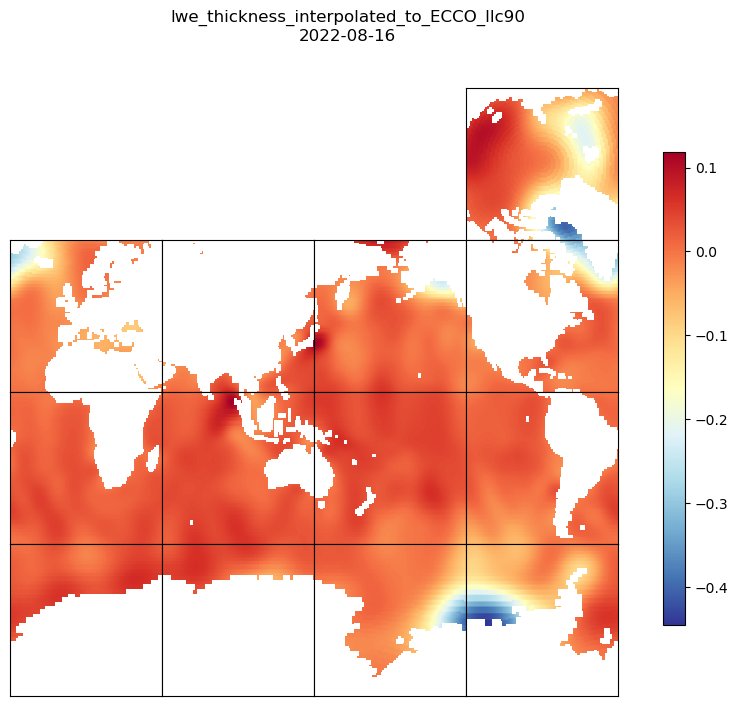

In [55]:
field_ds = field_ds_list[0]
plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]])


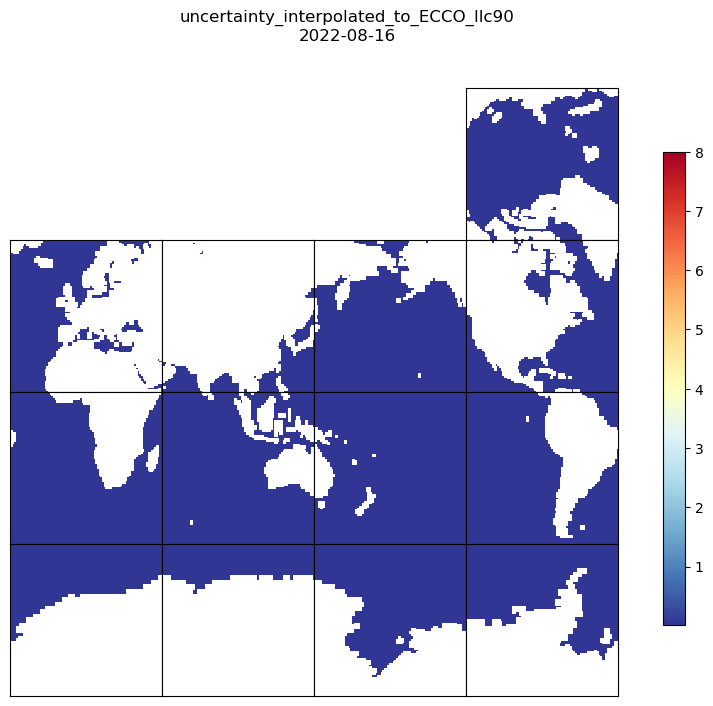

In [56]:
field_ds = field_ds_list[1]
plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]], vmax=8)